In [1]:
from datetime import datetime, timedelta
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [2]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [253]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max", progress=False)

In [186]:
s = time.time()
# data = get_data(get_all_tickers())
data = get_data("ABEO")
data_cop = data.copy()
print(time.time() - s)

[*********************100%***********************]  1 of 1 completed
0.6461215019226074


### Strategy and more shit

### Parsing initial dataframe

In [5]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["High"].rolling("365D").max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    
    # df["doh"] = df.index.where(df["High52"] != df["High52"].shift())
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [152]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200, trail_stop=5):
    df = parsed_data.copy()

    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["High"].shift(-1) > df["High52"]
    buy_cond2 = (df.index - df["doh"] < time_thresh2)  & (df.index - df["doh"] > time_thresh1)
    
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    #Devide to a lot of dataframes
    df["Group"] = (df["Strategy"] == 1).cumsum()
    trades_df = {grp: df_grp for grp, df_grp in df.groupby("Group")}
    conc_tmp_df = pd.DataFrame()
    
    for key, tmp_df in trades_df.items():
        tmp_df["trade_high"] = tmp_df["High"].cummax()
        sell_cond = (((tmp_df["trade_high"] - tmp_df["Close"]) / tmp_df["trade_high"]) * 100) > trail_stop
        tmp_df.loc[sell_cond, "Strategy"] = -1
        conc_tmp_df = pd.concat([conc_tmp_df, tmp_df])
    # df = pd.concat(dfs.values())
    df = conc_tmp_df.copy()
    df.drop('Group', axis=1, inplace=True)
    # Sell cond- sell after 3 days, just for testing because I don't know yet how I should do it
    # sell_cond = ((df["Close"] - df["Close"].shift(2)) / df["Close"].shift(2)) * 100  # Sell if the percent 2 days ago gone down 3%
    # sell_cond = df["Strategy"].shift(3) == 1
    # df.loc[sell_cond, "Strategy"] = -1
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    # df["Stocks bought"] = df["pos"] * s_money//df["Open"]
    # df['Stocks bought'] = df['Stocks bought'].replace(to_replace=np.nan, method='ffill')
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
      
    return df

In [153]:
def sim(df1):
    df = df1.copy()
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    
    # df['prev buy'] = df.index.where(df['Strategy'] == 1)
    # df['prev buy'] = df['prev buy'].shift(1).ffill()
    # df['prev buy'] = df['prev buy'].fillna(-1)
    # valid_idx = df["prev buy"].isin(df.index)

    # df["bought price"] = df["prev buy"].loc[valid_idx].map(df["Close"]) * df["pos"]

    # df.loc[df["pos"] == 0, "prev buy"] = np.NaN
    # df.loc[df["bought price"] == 0, "bought price"] = np.NaN
    
    # tmp = df.copy()
    # df['test'] = [i - df.index.get_loc(date) if date in df.index else np.NaN for i, date in enumerate(df["prev buy"])]
    # df["trail"] = np.NaN
    
    return df

In [255]:
def optimizer(ticker, time_thresh1, time_thresh2, trail_stop):

    data = get_data(ticker)
    parsed = parse_data(data)
    i = 0
    results = pd.DataFrame(columns=["time thresh1", "time thresh2", "trail stop", "return", "dataframe"])
    for tt1 in time_thresh1:
        for tt2 in time_thresh2:
            for trs in trail_stop:       
                strat_df = strategy(parsed, tt1, tt2, trs)
                res = sim(strat_df)
                retrn = res["sReturn"][-1]
                new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "return": [retrn], "dataframe": [res]})
                results = pd.concat([results, new_row], ignore_index=True)
    return results


time_thresh1 = range(50, 80, 2)
time_thresh2 = range(100, 250, 5)
trail_stop = range(1, 10, 1)
# time_thresh1 = range(70, 80, 5)
# time_thresh2 = range(100, 200, 60)
# trail_stop = range(1, 10, 2)
tickers = ["ABEO", "ABIO", "ABVC", "ACHV", "ACER", "ACST", "AAIC", "ACRX", "ACOR", "ACET"]

s = time.time()
mult_opt = pd.DataFrame()
for ticker in tickers:
    opt = optimizer(ticker, time_thresh1, time_thresh2, trail_stop)
    # opt = opt.add_prefix(f"{ticker}_")
    opt.columns = pd.MultiIndex.from_product([[ticker], opt.columns])
    mult_opt = pd.concat([mult_opt, opt], axis=1, ignore_index=False)

print(time.time() - s)
mult_opt

2744.7880294322968


ABEO                                 \
     time thresh1 time thresh2 trail stop return   
0              50          100          1   1.06   
1              50          100          2   1.37   
2              50          100          3   1.19   
3              50          100          4   1.99   
4              50          100          5   2.35   
...           ...          ...        ...    ...   
4045           78          245          5   1.29   
4046           78          245          6   1.29   
4047           78          245          7   0.98   
4048           78          245          8   0.98   
4049           78          245          9   0.98   

                                                                ABIO  \
                                              dataframe time thresh1   
0                        Open         High        Cl...           50   
1                        Open         High        Cl...           50   
2                        Open         High        Cl...           50   
3                        Open         High        Cl...           50   
4                        Open         High        Cl...           50   
...                                                 ...          ...   
4045                     Open         High        Cl...           78   
4046                     Open         High        Cl...           78   
4047                     Open         High        Cl...           78   
4048                     Open         High        Cl...           78   
4049                     Open         High        Cl...           78   

                                     \
     time thresh2 trail stop return   
0             100          1   1.05   
1             100          2   1.05   
2             100          3   1.36   
3             100          4   1.36   
4             100          5   1.24   
...           ...        ...    ...   
4045          245          5   1.10   
4046          245          6   1.10   
4047          245          7   1.10   
4048          245          8   1.05   
4049          245          9   1.05   

                                                         ...         ACOR  \
                                              dataframe  ... time thresh1   
0                      Open       High      Close  V...  ...           50   
1                      Open       High      Close  V...  ...           50   
2                      Open       High      Close  V...  ...           50   
3                      Open       High      Close  V...  ...           50   
4                      Open       High      Close  V...  ...           50   
...                                                 ...  ...          ...   
4045                   Open       High      Close  V...  ...           78   
4046                   Open       High      Close  V...  ...           78   
4047                   Open       High      Close  V...  ...           78   
4048                   Open       High      Close  V...  ...           78   
4049                   Open       High      Close  V...  ...           78   

                                     \
     time thresh2 trail stop return   
0             100          1   1.01   
1             100          2   1.10   
2             100          3   1.10   
3             100          4   1.10   
4             100          5   1.10   
...           ...        ...    ...   
4045          245          5   1.66   
4046          245          6   2.29   
4047          245          7   2.84   
4048          245          8   2.85   
4049          245          9   2.91   

                                                                ACET  \
                                              dataframe time thresh1   
0                  Open   High  Close  Volume  High5...           50   
1                  Open   High  Close  Volume  High5...           50   
2                  Open   High  Close  Volume  High5...           50   
3                  Op

In [187]:
df = parse_data(data_cop)
df = strategy(df)
df = sim(df)
df

,Open,High,Close,Volume,High52,doh,Strategy,pos,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,
1980-09-19,"2,500,000.00","2,625,000.00","2,500,000.00",0,"2,625,000.00",1900-01-01,0,NaN,"2,625,000.00",NaN,NaN,NaN,NaN
1980-09-22,"3,000,000.00","3,062,500.00","3,000,000.00",0,"3,062,500.00",1900-01-01,0,NaN,"3,062,500.00",NaN,0.18,NaN,1.20
1980-09-23,"3,062,500.00","3,187,500.00","3,062,500.00",0,"3,187,500.00",1900-01-01,0,NaN,"3,187,500.00",NaN,0.02,NaN,1.22
1980-09-24,"2,937,500.00","2,937,500.00","2,875,000.00",0,"3,187,500.00",1900-01-01,-1,NaN,"3,187,500.00",NaN,-0.06,NaN,1.15
1980-09-25,"3,000,000.00","3,125,000.00","3,000,000.00",0,"3,187,500.00",1900-01-01,-1,0.00,"3,187,500.00",0.00,0.04,1.00,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,3.90,4.09,4.06,78800,5.80,2023-07-11,-1,0.00,"6,250.00",0.00,0.03,1.79,0.00
2023-08-29,4.06,4.30,4.11,180100,5.80,2023-07-11,-1,0.00,"6,250.00",0.00,0.01,1.79,0.00
2023-08-30,4.11,4.50,4.34,182000,5.80,2023-07-11,-1,0.00,"6,250.00",0.00,0.05,1.79,0.00


In [9]:
df["pos"].value_counts()
df.index[df['Strategy'] == 1].tolist()[:10]

[Timestamp('1965-04-14 00:00:00'),
 Timestamp('1965-07-23 00:00:00'),
 Timestamp('1975-03-07 00:00:00'),
 Timestamp('1978-02-08 00:00:00'),
 Timestamp('1979-01-08 00:00:00'),
 Timestamp('1984-08-02 00:00:00'),
 Timestamp('1985-05-31 00:00:00'),
 Timestamp('1985-12-04 00:00:00'),
 Timestamp('1988-05-27 00:00:00'),
 Timestamp('1989-03-14 00:00:00')]

<Axes: xlabel='Date'>

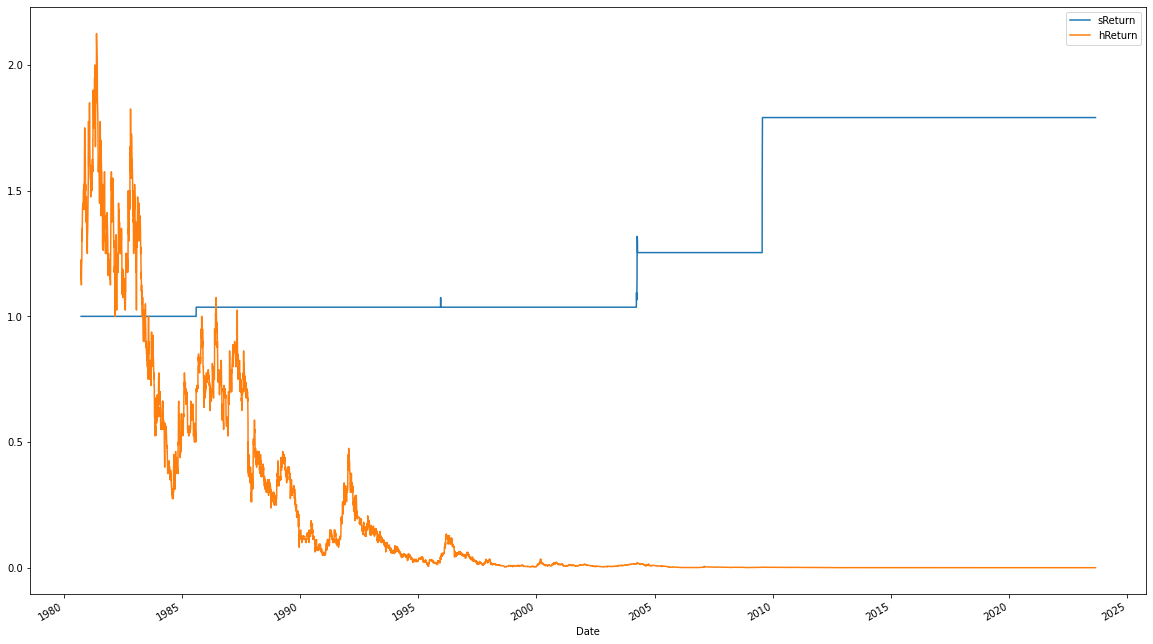

In [189]:
# df[["sReturn", "hReturn"]].plot(figsize=(20,12))
df["sReturn"].plot(figsize=(20,12))

In [132]:
# df[815:835]
# df["1965-07-20":"1965-10-05"]
df[1400:1450]

,Open,High,Close,Volume,High52,doh,Strategy,pos,Group,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
2023-06-06,4.20,4.41,4.33,687800,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.03,1.00,0.33
2023-06-07,4.32,4.45,4.36,682000,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.01,1.00,0.34
2023-06-08,4.33,4.44,4.41,548200,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.01,1.00,0.34
2023-06-09,4.43,4.47,4.43,553900,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.00,1.00,0.34
2023-06-12,4.49,4.57,4.45,789700,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.00,1.00,0.34
2023-06-13,4.50,4.52,4.52,696500,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.02,1.00,0.35
2023-06-14,4.53,4.62,4.55,591900,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.01,1.00,0.35
2023-06-15,4.58,4.66,4.59,649100,5.92,2023-02-02,-1,0.00,0,14.63,0.00,0.01,1.00,0.35
2023-06-16,4.62,4.62,4.57,1401700,5.92,2023-02-02,-1,0.00,0,14.63,-0.00,-0.00,1.00,0.35


In [12]:
df["test"].value_counts()

1.00    25
2.00    25
3.00    25
Name: test, dtype: int64

In [13]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit      190.68
Hold         27,143.11
dtype: float64

In [14]:
df["sReturn"].nsmallest(10)

Date
1965-04-15   1.01
1965-04-20   1.02
1965-04-21   1.02
1965-04-22   1.02
1965-04-23   1.02
1965-04-26   1.02
1965-04-27   1.02
1965-04-28   1.02
1965-04-29   1.02
1965-04-30   1.02
Name: sReturn, dtype: float64

In [248]:
df

Empty DataFrame
Columns: []
Index: []

In [260]:
mult_opt["ABEO"].sort_values("return", ascending=0)

,time thresh1,time thresh2,trail stop,return,dataframe
808,54,245,8,3.75,Open High Cl...
529,52,240,8,3.75,Open High Cl...
1060,56,235,8,3.75,Open High Cl...
1078,56,245,8,3.75,Open High Cl...
511,52,230,8,3.75,Open High Cl...
...,...,...,...,...,...
3858,78,140,7,0.78,Open High Cl...
3932,78,180,9,0.78,Open High Cl...
3931,78,180,8,0.78,Open High Cl...
3930,78,180,7,0.78,Open High Cl...
